In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import coursera_competition_udfs as udf
import gc
import pickle

from scipy.stats import percentileofscore
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, recall_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

# Data

## Load monthly sales and features data 

- First, we aggregate sales data by month, where for each month we create a grid of all the shops and items that have sales in that month. (Note that all other combinations would yield rows or columns of zeroes, but this introduces survivor bias). We then stack monthly time series data for all such shop-item pairs.
- Then we created lagged sales of the 3 types of sales data: previous monthly sales of the shop_item pair, and previous monthly sales of the shop, and item, for different lag periods
- Finally we merge lagged sales data with other information, such as seasonality features
- Note that train and test data are concatenated and features generated altogether (ok for Kaggle and more convenient)

In [2]:
# all_sales = udf.load_all_monthly_sales()

In [3]:
pkl_name = './monthly_sales_grid_lag_1_2_3_6_12_seasonality_items_shops.pkl'
all_sales = pd.read_pickle(pkl_name)

In [4]:
all_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 29 columns):
date_block_num             int64
item_id                    int64
shop_id                    int64
target                     float64
target_lag_1               int64
target_item_lag_1          int64
target_shop_lag_1          int64
target_lag_2               int64
target_item_lag_2          int64
target_shop_lag_2          int64
target_lag_3               int64
target_item_lag_3          int64
target_shop_lag_3          int64
target_lag_6               int64
target_item_lag_6          int64
target_shop_lag_6          int64
target_lag_12              int64
target_item_lag_12         int64
target_shop_lag_12         int64
target_shop_zero           bool
target_item_zero           bool
target_shop_recent_zero    bool
target_item_recent_zero    bool
december                   bool
Q1                         bool
Q4                         bool
item_category_id           int64
i

In [5]:
# sanity check: no missing attributes other than test set label
nul_cols = all_sales.isnull().sum()
nul_cols[nul_cols>0]

target    214200
dtype: int64

## Create training and validation data

In [6]:
# encode categorical cols
categ_cols = ['item_id', 'shop_id', 'item_category_id', 'item_category_group', 'shop_city']
all_sales = udf.label_encode_categ_cols(all_sales, categ_cols)

label encoding item_id and saving to enc_item_id.pickle
label encoding shop_id and saving to enc_shop_id.pickle
label encoding item_category_id and saving to enc_item_category_id.pickle
label encoding item_category_group and saving to enc_item_category_group.pickle
label encoding shop_city and saving to enc_shop_city.pickle


In [7]:
# make training and validation data
X_train, X_val, y_train, y_val = udf.train_test_split_by_month(all_sales)

# for training on clipped target values
y_train_clip, y_val_clip = y_train.clip(0, 20), y_val.clip(0, 20)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Test data: date_block_num [33]
Number of observations in train: 6186922
Number of observations in test: 238172
Number of attributes: 28


# Model selection

## LGBM

### Training lgbm with original target values

In [8]:
# # train lgbm with original labels

# params_orig = {
#                'max_depth': 8,  # reduce to increase regularization
#                'bagging_fraction': 0.6, 
#                'feature_fraction': 0.7, # reduce to increase regularization
#                'min_data_in_leaf': 1000, 
#                'learning_rate': 0.01, 
#                'bagging_freq':1,
#                 'objective': 'regression', 
#                 'metric': 'rmse',
#                'nthread':4, # parallel computation
#                'verbose':0
#               }
# rounds_orig = 2500

# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
# result = {}

# bst = lgb.train(params = params_orig,
#                 train_set = lgb_train,
#                 num_boost_round = rounds_orig,
#                 valid_sets=[lgb_train, lgb_val],
#                 valid_names=['train', 'val'],
#                 categorical_feature=categ_cols,
#                 early_stopping_rounds=20,
#                 evals_result=result,
#                 verbose_eval=100,
#                 keep_training_booster=True)

# # extract predictions of the best model for further analysis
# pred_train_bst = bst._Booster__inner_predict(data_idx=0)
# pred_val_bst = bst._Booster__inner_predict(data_idx=1)

# lgb.plot_metric(result);

In [9]:
# # saving trained model and predictions on train and val set
# filename = 'lgbm_bst_2018_12_20'
# bst.save_model(filename + '.txt', num_iteration=bst.best_iteration);

# with open(filename + '_pred_train.pkl', 'wb') as f:
#     pickle.dump(pred_train_bst, f)

# with open(filename + '_pred_val.pkl', 'wb') as f:
#     pickle.dump(pred_val_bst, f)

In [10]:
filename = 'lgbm_bst_2018_12_20'

bst = lgb.Booster(model_file=filename + '.txt')

with open(filename + '_pred_train.pkl', 'rb') as f:
    pred_train_bst = pickle.load(f)

with open(filename + '_pred_val.pkl', 'rb') as f:
    pred_val_bst = pickle.load(f)

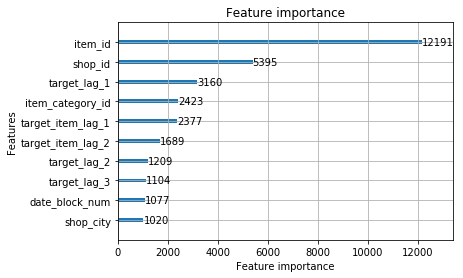

In [11]:
lgb.plot_importance(bst, max_num_features=10);

In [12]:
print('predictions on original values')
udf.train_test_metrics(y_train, y_val, pred_train_bst, pred_val_bst)

predictions on original values


,R-squared,RMSE
train,0.468,2.577
val,0.190,4.809


In [13]:
pred_val_bst.min(), pred_val_bst.max()

(-7.3282750215249655, 224.36224686965906)

In [14]:
print('predictions on original values')
udf.train_test_metrics(y_train_clip,
                       y_val_clip,
                       np.clip(pred_train_bst, 0, 20),
                       np.clip(pred_val_bst, 0, 20))

predictions on original values


,R-squared,RMSE
train,0.501,0.839
val,0.075,1.093


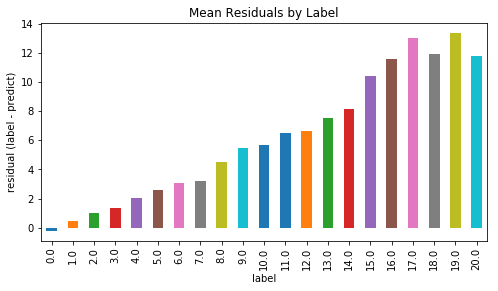

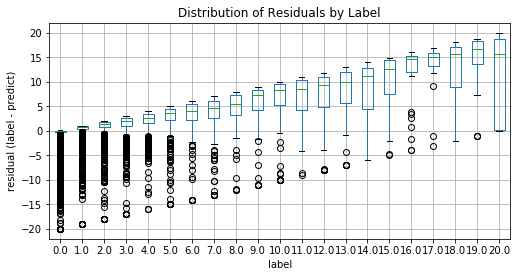

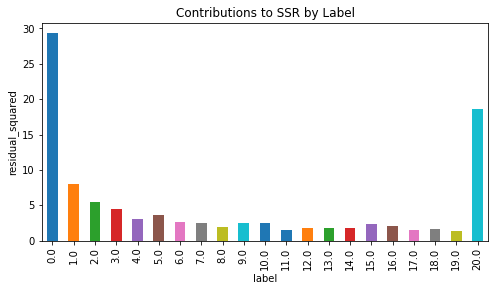

confusion matrix of label vs predict zero sales:
[[ 31168    303]
 [180387  26314]]


In [15]:
udf.clipped_error_analysis(y_val_clip, np.clip(pred_val_bst, 0, 20));

### Train lgbm on clipped target values

In [16]:
# # train lgbm with clipped labels

# params_clip = {
#                'max_depth': 8,  # reduce to increase regularization
#                'bagging_fraction': 0.6, 
#                'feature_fraction': 0.7, # reduce to increase regularization
#                'min_data_in_leaf': 1000, 
#                'learning_rate': 0.01, 
#                'bagging_freq':1,
#                 'objective': 'regression', 
#                 'metric': 'rmse',
#                'nthread':4, # parallel computation
#                'verbose':0
#               }
# rounds_clip = 1000

# lgb_train_clip = lgb.Dataset(X_train, y_train_clip)
# lgb_val_clip = lgb.Dataset(X_val, y_val_clip, reference=lgb_train_clip)
# result_clip = {}

# bst_clip = lgb.train(params = params_clip,
#                 train_set = lgb_train_clip,
#                 num_boost_round = rounds_clip,
#                 valid_sets=[lgb_train_clip, lgb_val_clip],
#                 valid_names=['train_clip', 'val_clip'],
#                 categorical_feature=categ_cols,
#                 early_stopping_rounds=20,
#                 evals_result=result_clip,
#                 verbose_eval=10,
#                 keep_training_booster=True)

# # extract predictions of the best model for further analysis
# pred_train_bst_clip = bst_clip._Booster__inner_predict(data_idx=0)
# pred_val_bst_clip = bst_clip._Booster__inner_predict(data_idx=1)

# lgb.plot_metric(evals_result);

In [17]:
# # saving trained model and predictions on train and val set
# filename = 'lgbm_bst_clip_2018_12_20'
# bst_clip.save_model(filename + '.txt', num_iteration=bst_clip.best_iteration);

# with open(filename + '_pred_train.pkl', 'wb') as f:
#     pickle.dump(pred_train_bst_clip, f)

# with open(filename + '_pred_val.pkl', 'wb') as f:
#     pickle.dump(pred_val_bst_clip, f)

#### Load trained model for error analysis

In [18]:
filename = 'lgbm_bst_clip_2018_12_20'

bst_clip = lgb.Booster(model_file=filename + '.txt')

with open(filename + '_pred_train.pkl', 'rb') as f:
    pred_train_bst_clip = pickle.load(f)

with open(filename + '_pred_val.pkl', 'rb') as f:
    pred_val_bst_clip = pickle.load(f)

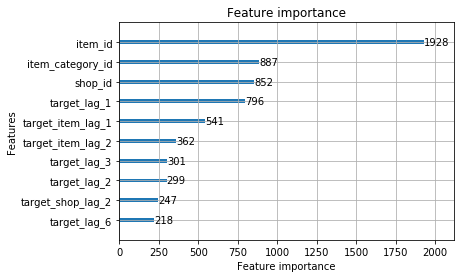

In [19]:
lgb.plot_importance(bst_clip, max_num_features=10);

In [20]:
udf.train_test_metrics(y_train_clip, y_val_clip, pred_train_bst_clip, pred_val_bst_clip)

,R-squared,RMSE
train,0.533,0.812
val,0.275,0.968


In [21]:
pred_train_bst_clip.min(), pred_train_bst_clip.max()

(0.04587183862909089, 18.527172802047712)

In [22]:
pred_val_bst_clip.min(), pred_val_bst_clip.max()

(0.0495819526928173, 18.424902559161314)

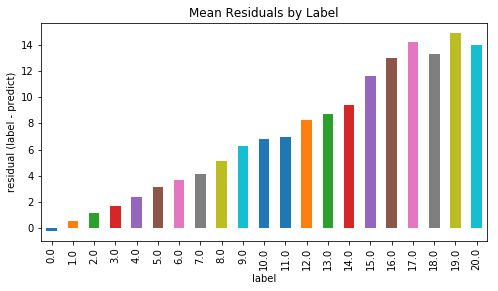

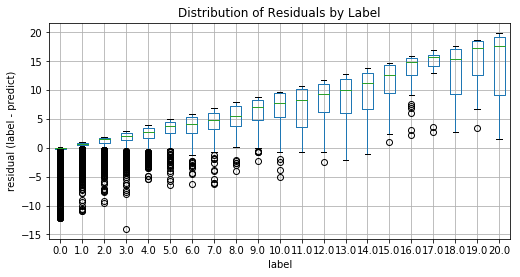

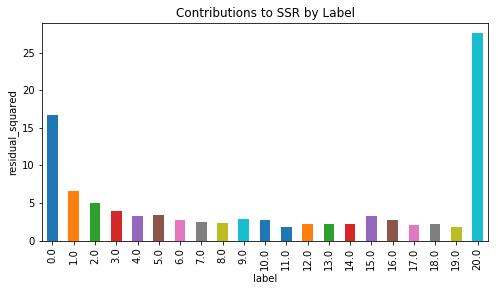

confusion matrix of label vs predict zero sales:
[[ 31471      0]
 [206701      0]]


In [23]:
udf.clipped_error_analysis(y_val_clip, pred_val_bst_clip);

Observation: 
- our model consistently underpredicts the true sales
- the prediction error is increasing in the true sales, i.e. we are really bad at predicting positive sales.
- in fact, our model never predicts zero, whereas the true target is predominantly zero. Scores hover above 0.22. 
- the vast majority of predictions are between 0 and 1. Consider rounding and/or doing regression?

It is hard to predict well for several reasons:
- the true values are mostly zero. akin to unbalanced problem?
- the true values are integers whereas the predictions, treating it as a regression problem, are real
- it is hard to predict exactly zero. 

The high RMSE on the validation set is driven by:
- wrong predictions of the ones with true value 20, which are most often predicted close to zero. This is due to the rmse property that high 
- rounding the predictions between 0 and 1 didn't help much in terms of mse becuase it decreased the residuals for true values of 0 but increased the ones for 1. could consider shifting the threshold 

# Predict on test set

In [8]:
# make full training and testing data
X_all, X_test, y_all, y_test = udf.train_test_split_by_month(all_sales, test_start=34)

# for training on clipped target values
y_all_clip, y_test_clip = y_all.clip(0, 20), y_test.clip(0, 20)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
Test data: date_block_num [34]
Number of observations in train: 6425094
Number of observations in test: 214200
Number of attributes: 28


In [19]:
model_select = lgb.Booster(model_file='lgbm_bst_model_clip.txt')  #init model
pred_test = model_select.predict(all_test)

In [20]:
pred_submit = all_test[['item_id', 'shop_id']].copy().reset_index(drop=True)
pred_submit['target'] = pred_test

# inverse the item and shop ids
pred_submit = udf.inverse_label_encode_categ_cols(pred_submit, ['item_id', 'shop_id'])

inverse label encoding item_id from file enc_item_id.pickle
inverse label encoding shop_id from file enc_shop_id.pickle


/home/johanna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/johanna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
test_data = udf.load_test_data()

#### mismatch between shop-item pairs in test and submit?! 

In [23]:
pred_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
item_id    214200 non-null int64
shop_id    214200 non-null int64
target     214200 non-null float64
dtypes: float64(1), int64(2)
memory usage: 4.9 MB


In [24]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [25]:
pred_submit['item_id'].nunique(), pred_submit['shop_id'].nunique()

(5100, 42)

In [26]:
test_data['item_id'].nunique(), test_data['shop_id'].nunique()

(5100, 42)

In [27]:
submit_shops = set(pred_submit['shop_id'])

In [28]:
test_shops = set(test_data['shop_id'])

In [29]:
submit_shops-test_shops

set()

In [30]:
test_shops - submit_shops

set()

### Create submission file 

In [31]:
# create submission file with IDs from test data
submit = (pd.merge(test_data, pred_submit, how='left', on=['shop_id', 'item_id'])
              .rename(columns={'target': 'item_cnt_month'})
                  .drop(columns=['shop_id', 'item_id'])
          )

In [32]:
submit.shape

(214200, 2)

In [34]:
submit.isnull().sum()

ID                0
item_cnt_month    0
dtype: int64

In [35]:
submit.to_csv('submission_lgbm_lags_and_id_features.csv', index=False)
# yields public leaderboard score of 